In [58]:
# Import pandas for data manipulation and DataFrame operations
import pandas as pd

# Import seaborn for statistical data visualization
import seaborn as sns

# Import matplotlib for creating plots and charts
import matplotlib.pyplot as plt

# Import numpy for numerical computations and array operations
import numpy as np

# Import utility to check whether a column has numeric data type
from pandas.api.types import is_numeric_dtype

# Import LabelEncoder to convert categorical values into numerical labels
from sklearn.preprocessing import LabelEncoder

# Import train_test_split for splitting data and GridSearchCV for hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV

# Import SMOTE to handle class imbalance by oversampling the minority class
from imblearn.over_sampling import SMOTE

# Import Decision Tree classifier model
from sklearn.tree import DecisionTreeClassifier

# Import Logistic Regression classifier model
from sklearn.linear_model import LogisticRegression

# Import K-Nearest Neighbors classifier model
from sklearn.neighbors import KNeighborsClassifier

# Import evaluation metrics for classification models
from sklearn.metrics import (
    confusion_matrix,        # To evaluate prediction correctness
    classification_report,   # To generate precision, recall, and F1-score
    accuracy_score,          # To compute overall accuracy
    f1_score,                # To measure balance between precision and recall
    roc_auc_score,           # To compute area under the ROC curve
    roc_curve,               # To generate ROC curve points
    auc                      # To calculate the area under the curve
)

In [59]:
# Load the built-in Titanic dataset from Seaborn into a pandas DataFrame
df = sns.load_dataset('titanic')

# Display the first five rows of the DataFrame to preview the dataset
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [60]:
# Display a concise summary of the DataFrame including column names, data types, and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [61]:
# Return the number of rows and columns in the DataFrame as a tuple (rows, columns)
df.shape

(891, 15)

In [62]:
# Count the total number of missing (NaN) values in each column of the DataFrame
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [63]:
# Count the number of duplicate rows in the DataFrame
df.duplicated().sum()

np.int64(107)

In [64]:
# Remove all duplicate rows from the DataFrame and update df
df = df.drop_duplicates()

# Check the new shape of the DataFrame after removing duplicates
df.shape

(784, 15)

In [65]:
# Drop the 'embarked' and 'deck' columns from the DataFrame as they are not needed
df = df.drop(['embarked', 'deck', 'alone'], axis=1)

# Fill missing values in the 'age' column with the column's mean value
df['age'] = df['age'].fillna(df['age'].mean())

# Fill missing values in the 'embark_town' column using forward fill method
df['embark_town'] = df['embark_town'].ffill()

In [66]:
# Initialize an empty dictionary to store the number of outliers for each numerical column
outlier_count = {}

# Loop through all numerical columns in the DataFrame
for col in df.select_dtypes(include='number').columns:
    # Calculate the first quartile (25th percentile) of the column
    q1 = df[col].quantile(.25)
    
    # Calculate the third quartile (75th percentile) of the column
    q3 = df[col].quantile(.75)

    # Compute the interquartile range (IQR)
    iqr = q3 - q1

    # Determine the upper whisker (1.5*IQR above Q3)
    upper_whisker = q3 + 1.5 * iqr
    
    # Determine the lower whisker (1.5*IQR below Q1)
    lower_whisker = q1 - 1.5 * iqr

    # Count the number of outliers in the column
    counts = (df[col] > upper_whisker) | (df[col] < lower_whisker)
    outlier_count[col] = counts.sum()

# Convert the outlier count dictionary into a DataFrame for better visualization
outlier_df  = pd.DataFrame(
    {
        'Columns': outlier_count.keys(),      # Column names
        'Outlier Count': outlier_count.values()  # Corresponding number of outliers
    }
)

# Display the DataFrame showing number of outliers per numerical column
outlier_df

,Columns,Outlier Count
0,survived,0
1,pclass,0
2,age,39
3,sibsp,39
4,parch,15
5,fare,102


In [67]:
# Define a function to handle outliers in a numerical column using the IQR method
def outlier(df, col2):
    
    # Calculate the first quartile (25th percentile) of the selected column
    q1 = df[col2].quantile(.25)
    # Calculate the third quartile (75th percentile) of the selected column
    q3 = df[col2].quantile(.75)

    # Compute the interquartile range (IQR)
    iqr = q3 - q1

    # Define the upper boundary for outlier capping
    upper_whisker = q3 + 1.5 * iqr
    # Define the lower boundary for outlier capping
    lower_whisker = q1 - 1.5 * iqr

    # Cap the outliers by clipping values outside the IQR range
    df[col2] = np.clip(df[col2], lower_whisker, upper_whisker)
    
    # Return the updated DataFrame with outliers handled
    return df


In [68]:
# Create a copy of the original DataFrame to preserve the raw data
df_clean = df.copy()

# Apply the outlier handling function to each numerical column
for col4 in df.select_dtypes(include='number').columns:
    
    # Cap outliers in the current numerical column using the IQR method
    df_clean = outlier(df_clean, col4)

# Replace the original DataFrame with the cleaned version
df = df_clean.copy()

Visualization

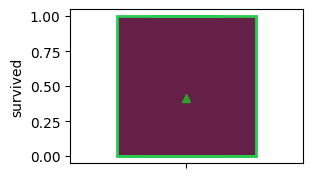

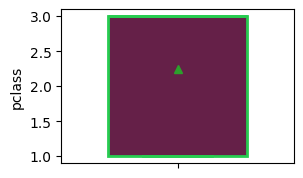

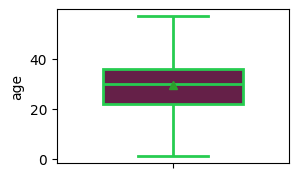

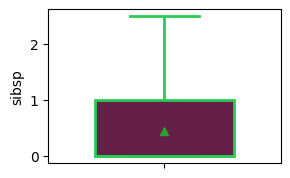

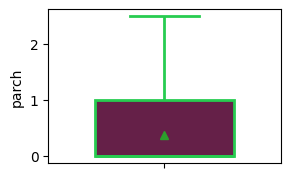

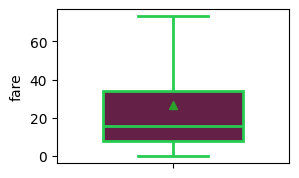

In [69]:
# Loop through all numerical columns in the DataFrame to visualize outliers
for col3 in df.select_dtypes(include='number').columns:
    
    # Create a new figure with a fixed size for each boxplot
    plt.figure(figsize=(3,2))
    
    # Draw a boxplot for the current numerical column to visualize distribution and outliers
    sns.boxplot(
        df[col3],              # Data for the boxplot
        color="#70154A",        # Set the fill color of the box
        linecolor="#27CC50",    # Set the color of the box edges and whiskers
        linewidth=2,            # Define the thickness of box edges
        showmeans=True,         # Display the mean value on the boxplot
        width=0.6               # Control the width of the box
    )
    
    # Display the boxplot for the current column
    plt.show()

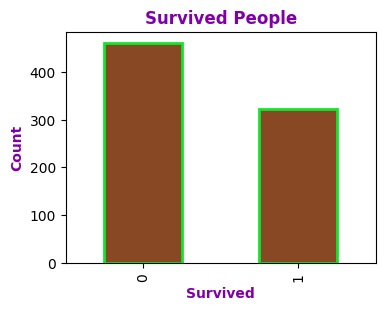

In [70]:
# Create a new figure with a specified size for the bar chart
plt.figure(figsize=(4,3))

# Plot a bar chart showing the count of survived and non-survived passengers
df['survived'].value_counts().plot(
    kind='bar',              # Specify bar chart type
    color='#894824',         # Set the bar fill color
    edgecolor="#0FE72C",     # Set the border color of the bars
    linewidth=2              # Define the thickness of the bar edges
)

# Set the title of the plot with custom color and font weight
plt.title('Survived People', color="#8000A7", fontweight='bold')

# Label the x-axis with custom styling
plt.xlabel('Survived', color="#8000A7", fontweight='bold')

# Label the y-axis with custom styling
plt.ylabel('Count', color="#8000A7", fontweight='bold')

# Display the bar chart
plt.show()

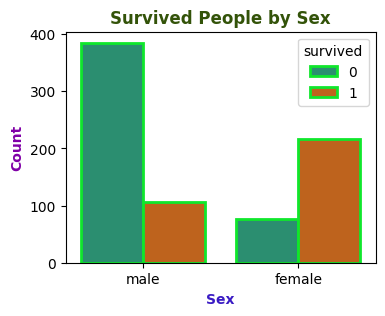

In [71]:
# Create a new figure with a specified size for the count plot
plt.figure(figsize=(4,3))

# Draw a count plot to compare survival counts by gender
sns.countplot(
    data=df,                 # Use the DataFrame as the data source
    x='sex',                 # Plot gender categories on the x-axis
    hue='survived',          # Separate counts based on survival status
    palette='Dark2',         # Apply the Dark2 color palette
    #color='#894824',        # Optional single color (commented out)
    edgecolor="#0FE72C",     # Set the border color of the bars
    linewidth=2              # Define the thickness of bar borders
)

# Set the title of the plot with custom styling
plt.title('Survived People by Sex', color="#335309", fontweight='bold')

# Label the x-axis with custom color and font weight
plt.xlabel('Sex', color="#3A1BC4", fontweight='bold')

# Label the y-axis with custom color and font weight
plt.ylabel('Count', color="#8000A7", fontweight='bold')

# Display the count plot
plt.show()

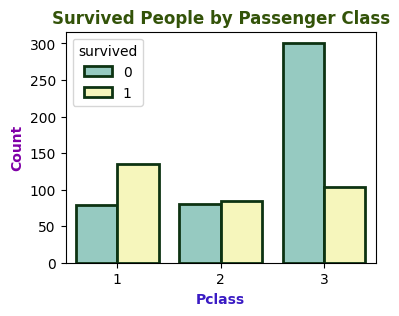

In [72]:
# Create a new figure with a specified size for the count plot
plt.figure(figsize=(4,3))

# Draw a count plot to compare survival counts by passenger class
sns.countplot(
    data=df,                 # Use the DataFrame as the data source
    x='pclass',              # Plot passenger class on the x-axis
    hue='survived',          # Separate counts based on survival status
    palette='Set3',          # Apply the Set3 color palette
    #color='#894824',        # Optional single color (commented out)
    edgecolor="#0D3312",     # Set the border color of the bars
    linewidth=2              # Define the thickness of bar borders
)

# Set the title of the plot with custom styling
plt.title('Survived People by Passenger Class', color="#335309", fontweight='bold')

# Label the x-axis with custom color and font weight
plt.xlabel('Pclass', color="#3A1BC4", fontweight='bold')

# Label the y-axis with custom color and font weight
plt.ylabel('Count', color="#8000A7", fontweight='bold')

# Display the count plot
plt.show()


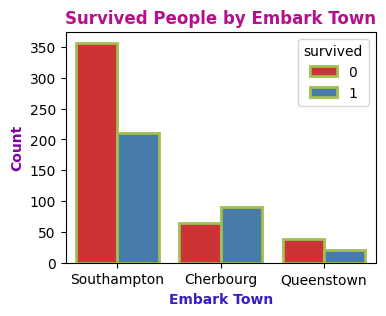

In [73]:
# Create a new figure with a specified size for the count plot
plt.figure(figsize=(4,3))

# Draw a count plot to compare survival counts by embarkation town
sns.countplot(
    data=df,                 # Use the DataFrame as the data source
    x='embark_town',         # Plot embarkation towns on the x-axis
    hue='survived',          # Separate counts based on survival status
    palette='Set1',          # Apply the Set1 color palette
    #color='#894824',        # Optional single color (commented out)
    edgecolor="#A1BE4F",     # Set the border color of the bars
    linewidth=2              # Define the thickness of bar borders
)

# Set the title of the plot with custom styling
plt.title('Survived People by Embark Town', color="#B60F8C", fontweight='bold')

# Label the x-axis with custom color and font weight
plt.xlabel('Embark Town', color="#3A1BC4", fontweight='bold')

# Label the y-axis with custom color and font weight
plt.ylabel('Count', color="#8000A7", fontweight='bold')

# Display the count plot
plt.show()


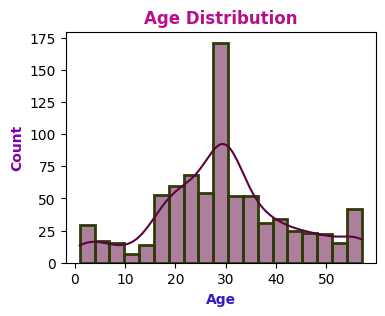

In [74]:
# Create a new figure with a specified size for the histogram
plt.figure(figsize=(4,3))

# Plot a histogram to visualize the age distribution with a KDE curve
sns.histplot(
    data=df,                 # Use the DataFrame as the data source
    x='age',                 # Plot age values on the x-axis
    kde=True,                # Display the kernel density estimation curve
    color="#5A033D",         # Set the fill color of the histogram
    edgecolor="#2E3B08",     # Set the border color of the histogram bars
    linewidth=2              # Define the thickness of bar borders
)

# Set the title of the plot with custom styling
plt.title('Age Distribution', color="#B60F8C", fontweight='bold')

# Label the x-axis with custom color and font weight
plt.xlabel('Age', color="#3A1BC4", fontweight='bold')

# Label the y-axis with custom color and font weight
plt.ylabel('Count', color="#8000A7", fontweight='bold')

# Display the histogram
plt.show()

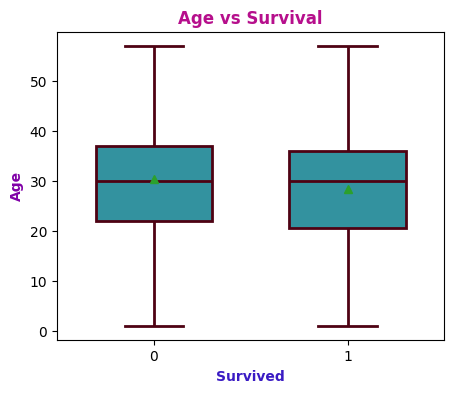

In [75]:
# Create a new figure with a specified size for the boxplot
plt.figure(figsize=(5,4))

# Draw a boxplot to visualize age distribution based on survival status
sns.boxplot(
    data=df,                 # Use the DataFrame as the data source
    x='survived',            # Plot survival status on the x-axis
    y='age',                 # Plot age on the y-axis
    color="#21A0B1",         # Set the fill color of the boxes
    linecolor="#4E0213",     # Set the border color of the boxes and whiskers
    linewidth=2,             # Define the thickness of box edges
    showmeans=True,          # Display the mean value as a marker
    width=0.6                # Set the width of the boxes
)

# Set the title of the plot with custom styling
plt.title('Age vs Survival', color="#B60F8C", fontweight='bold')

# Label the x-axis with custom color and font weight
plt.xlabel('Survived', color="#3A1BC4", fontweight='bold')

# Label the y-axis with custom color and font weight
plt.ylabel('Age', color="#8000A7", fontweight='bold')

# Display the boxplot
plt.show()

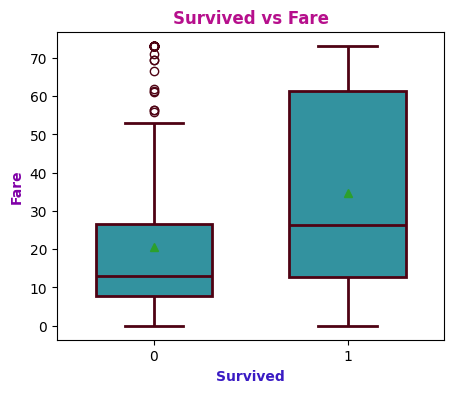

In [76]:
# Create a new figure with a specified size for the boxplot
plt.figure(figsize=(5,4))

# Draw a boxplot to visualize the fare distribution based on survival status
sns.boxplot(
    data=df,                 # Use the DataFrame as the data source
    x='survived',            # Plot survival status on the x-axis
    y='fare',                # Plot fare values on the y-axis
    color="#21A0B1",         # Set the fill color of the boxes
    linecolor="#4E0213",     # Set the border color of the boxes and whiskers
    linewidth=2,             # Define the thickness of box edges
    showmeans=True,          # Display the mean value as a marker
    width=0.6                # Set the width of the boxes
)

# Set the title of the plot with custom styling
plt.title('Survived vs Fare', color="#B60F8C", fontweight='bold')

# Label the x-axis with custom color and font weight
plt.xlabel('Survived', color="#3A1BC4", fontweight='bold')

# Label the y-axis with custom color and font weight
plt.ylabel('Fare', color="#8000A7", fontweight='bold')

# Display the boxplot
plt.show()

In [77]:
# Import LabelEncoder from sklearn (assumed already imported)
le = LabelEncoder()

# Loop through all columns in the DataFrame
for col5 in df.columns:
    
    # Check if the column is non-numeric (categorical)
    if not is_numeric_dtype(df[col5]):
        
        # Apply Label Encoding to convert categorical values to numerical labels
        df[col5] = le.fit_transform(df[col5])

In [78]:
# Convert the boolean column 'adult_male' to numerical values: True -> 1, False -> 0
df['adult_male'] = df['adult_male'].replace({True: 1, False: 0})

# Display the first five rows of the updated DataFrame
df.head()

C:\Users\MD Maruf\AppData\Local\Temp\ipykernel_12636\2139799209.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['adult_male'] = df['adult_male'].replace({True: 1, False: 0})


,survived,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,embark_town,alive
0,0,3,1,22.0,1.0,0.0,7.2500,2,1,1,2,0
1,1,1,0,38.0,1.0,0.0,71.2833,0,2,0,0,1
2,1,3,0,26.0,0.0,0.0,7.9250,2,2,0,2,1
3,1,1,0,35.0,1.0,0.0,53.1000,0,2,0,2,1
4,0,3,1,35.0,0.0,0.0,8.0500,2,1,1,2,0


In [79]:
# Separate the features (independent variables) by dropping the target column 'survived'
x = df.drop(['survived'], axis=1)

# Select the target column 'survived' as the dependent variable
y = df[['survived']]

In [80]:
# Split the dataset into training and testing sets
# 80% of the data will be used for training, 20% for testing
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y,                  # Features and target
    test_size=0.2,          # 20% of data for testing
    random_state=42         # Set random seed for reproducibility
)


In [81]:
# Display the first five rows of the training feature set to inspect the data
xtrain.head()

,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,embark_town,alive
864,2,1,24.000000,0.0,0.0,13.000000,1,1,1,2,0
141,3,0,22.000000,0.0,0.0,7.750000,2,2,0,2,1
730,1,0,29.000000,0.0,0.0,73.198375,0,2,0,2,1
56,2,0,21.000000,0.0,0.0,10.500000,1,2,0,2,1
451,3,1,29.869351,1.0,0.0,19.966700,2,1,1,2,0


In [82]:
# Display the first five rows of the training target set to inspect the labels
ytrain.head()

,survived
864,0
141,1
730,1
56,1
451,0


In [83]:
# Create a dictionary of machine learning models to train and compare
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),  # Decision Tree model
    'LogisticRegression': LogisticRegression(),         # Logistic Regression model
    'KNeighborsClassifier': KNeighborsClassifier()      # K-Nearest Neighbors model
}


Model Name: DecisionTreeClassifier
Train Score: 1.0
Test Score: 1.0
Confusion matrix:
 [[88  0]
 [ 0 69]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        69

    accuracy                           1.00       157
   macro avg       1.00      1.00      1.00       157
weighted avg       1.00      1.00      1.00       157

accuracy_score: 1.0
F1 Score: 1.0
ROC AUC score: 1.0


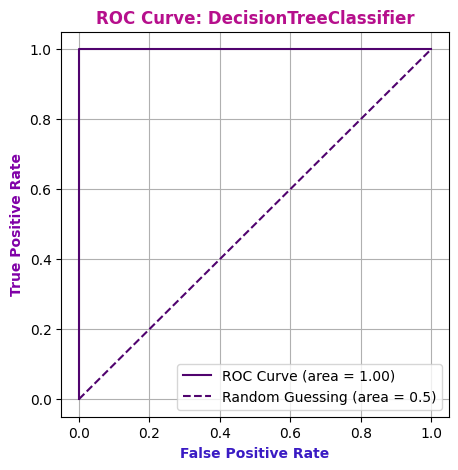

_____________________________
 
Model Name: LogisticRegression
Train Score: 1.0
Test Score: 1.0
Confusion matrix:
 [[88  0]
 [ 0 69]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        69

    accuracy                           1.00       157
   macro avg       1.00      1.00      1.00       157
weighted avg       1.00      1.00      1.00       157

accuracy_score: 1.0
F1 Score: 1.0
ROC AUC score: 1.0


c:\Users\MD Maruf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MD Maruf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


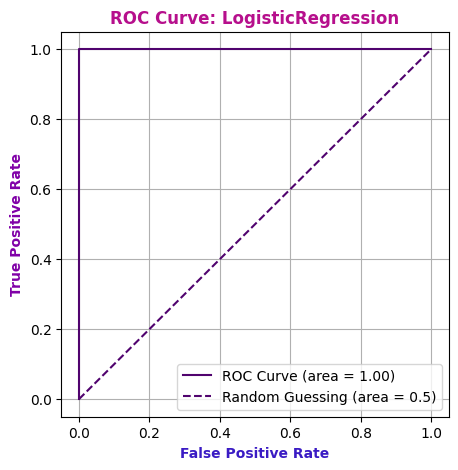

_____________________________
 
Model Name: KNeighborsClassifier
Train Score: 0.8293460925039873
Test Score: 0.7261146496815286
Confusion matrix:
 [[70 18]
 [25 44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77        88
           1       0.71      0.64      0.67        69

    accuracy                           0.73       157
   macro avg       0.72      0.72      0.72       157
weighted avg       0.72      0.73      0.72       157

accuracy_score: 0.7261146496815286


c:\Users\MD Maruf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


F1 Score: 0.724035346558934
ROC AUC score: 0.7954545454545454


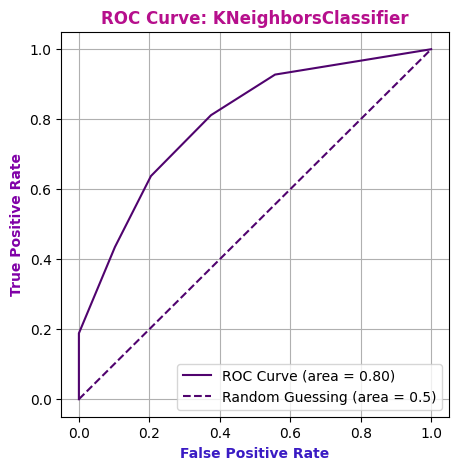

_____________________________
 


In [85]:
# Loop through each model in the models dictionary to train and evaluate
for model_name, model in models.items():
    
    # Print the name of the current machine learning model
    print("Model Name:", model_name)
    
    # Train (fit) the model using the training features and labels
    model1 = model.fit(xtrain, ytrain)
    
    # Calculate accuracy score on the training dataset
    train_sc = model1.score(xtrain, ytrain)
    print('Train Score:', train_sc)
    
    # Calculate accuracy score on the testing dataset
    test_sc = model1.score(xtest, ytest)
    print("Test Score:", test_sc)
    
    # Predict class labels for the test dataset
    pred_y = model1.predict(xtest)
    
    # Generate the confusion matrix using true and predicted labels
    cm = confusion_matrix(ytest, pred_y)
    print("Confusion matrix:\n", cm)
    
    # Generate a detailed classification report (precision, recall, f1-score)
    cl = classification_report(ytest, pred_y)
    print("Classification Report:\n", cl)
    
    # Compute the overall accuracy score
    acc = accuracy_score(ytest, pred_y)
    print("accuracy_score:", acc)

    # Compute the weighted F1 score to handle class imbalance
    f1 = f1_score(ytest, pred_y, average='weighted')
    print('F1 Score:', f1)

    # Check whether the model supports probability prediction
    if hasattr(model1, "predict_proba"):
        
        # Predict probabilities for the positive class (class = 1)
        pred_y_prov = model1.predict_proba(xtest)[:, 1]
        
        # Compute ROC AUC score using predicted probabilities
        roc = roc_auc_score(ytest, pred_y_prov)
        print("ROC AUC score:", roc)
        
        # Calculate False Positive Rate and True Positive Rate for ROC curve
        fpr, tpr, _ = roc_curve(ytest, pred_y_prov)
        
        # Calculate area under the ROC curve
        roc_auc = auc(fpr, tpr)

        # Create a new figure for the ROC curve
        plt.figure(figsize=(5,5))
        
        # Plot the ROC curve
        plt.plot(
            fpr, tpr,
            color="#50036E",
            label=f"ROC Curve (area = {roc_auc:.2f})"
        )
        
        # Plot the diagonal reference line (random guessing)
        plt.plot(
            [0,1], [0,1],
            color="#50036E",
            linestyle="--",
            label='Random Guessing (area = 0.5)'
        )
        
        # Set the title of the ROC curve plot
        plt.title(
            f'ROC Curve: {model_name}',
            color="#B60F8C",
            fontweight='bold'
        )

        # Label the x-axis of the plot
        plt.xlabel(
            'False Positive Rate',
            color="#3A1BC4",
            fontweight='bold'
        )

        # Label the y-axis of the plot
        plt.ylabel(
            'True Positive Rate',
            color="#8000A7",
            fontweight='bold'
        )
        
        # Display the legend in the bottom-right corner
        plt.legend(loc='lower right')
        
        # Add grid lines to the plot for better readability
        plt.grid(True)
        
        # Show the ROC curve plot
        plt.show()
        
    else:
        # Print message if the model does not support probability prediction
        print("ROC AUC Score: N/A")

    # Print a separator line between model evaluations
    print("_____________________________")
    print(" ")

